In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from dataset import DataSet
import pandas as pd
import utils
import numpy as np
from matplotlib import pyplot as plt
import torch
np.random.seed(2) 
torch.manual_seed(2)

## Peek at Light Curve Characteristics

In [2]:
folder = '../../datasets/mZTF_DR_data'
min_length=1
sep=','
start_col=1
lcs = DataSet(name=folder, sep=sep, start_col=start_col)
[lcs.add_band(os.path.join(folder, band_folder)) for band_folder in os.listdir(folder)]
lcs.filter(min_length=min_length)  
lcs.prune_outliers()  
#lcs.correct_z()
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()

validated 3398 files out of 3398 for band='r'
validated 3399 files out of 3399 for band='i'
validated 3399 files out of 3399 for band='g'


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


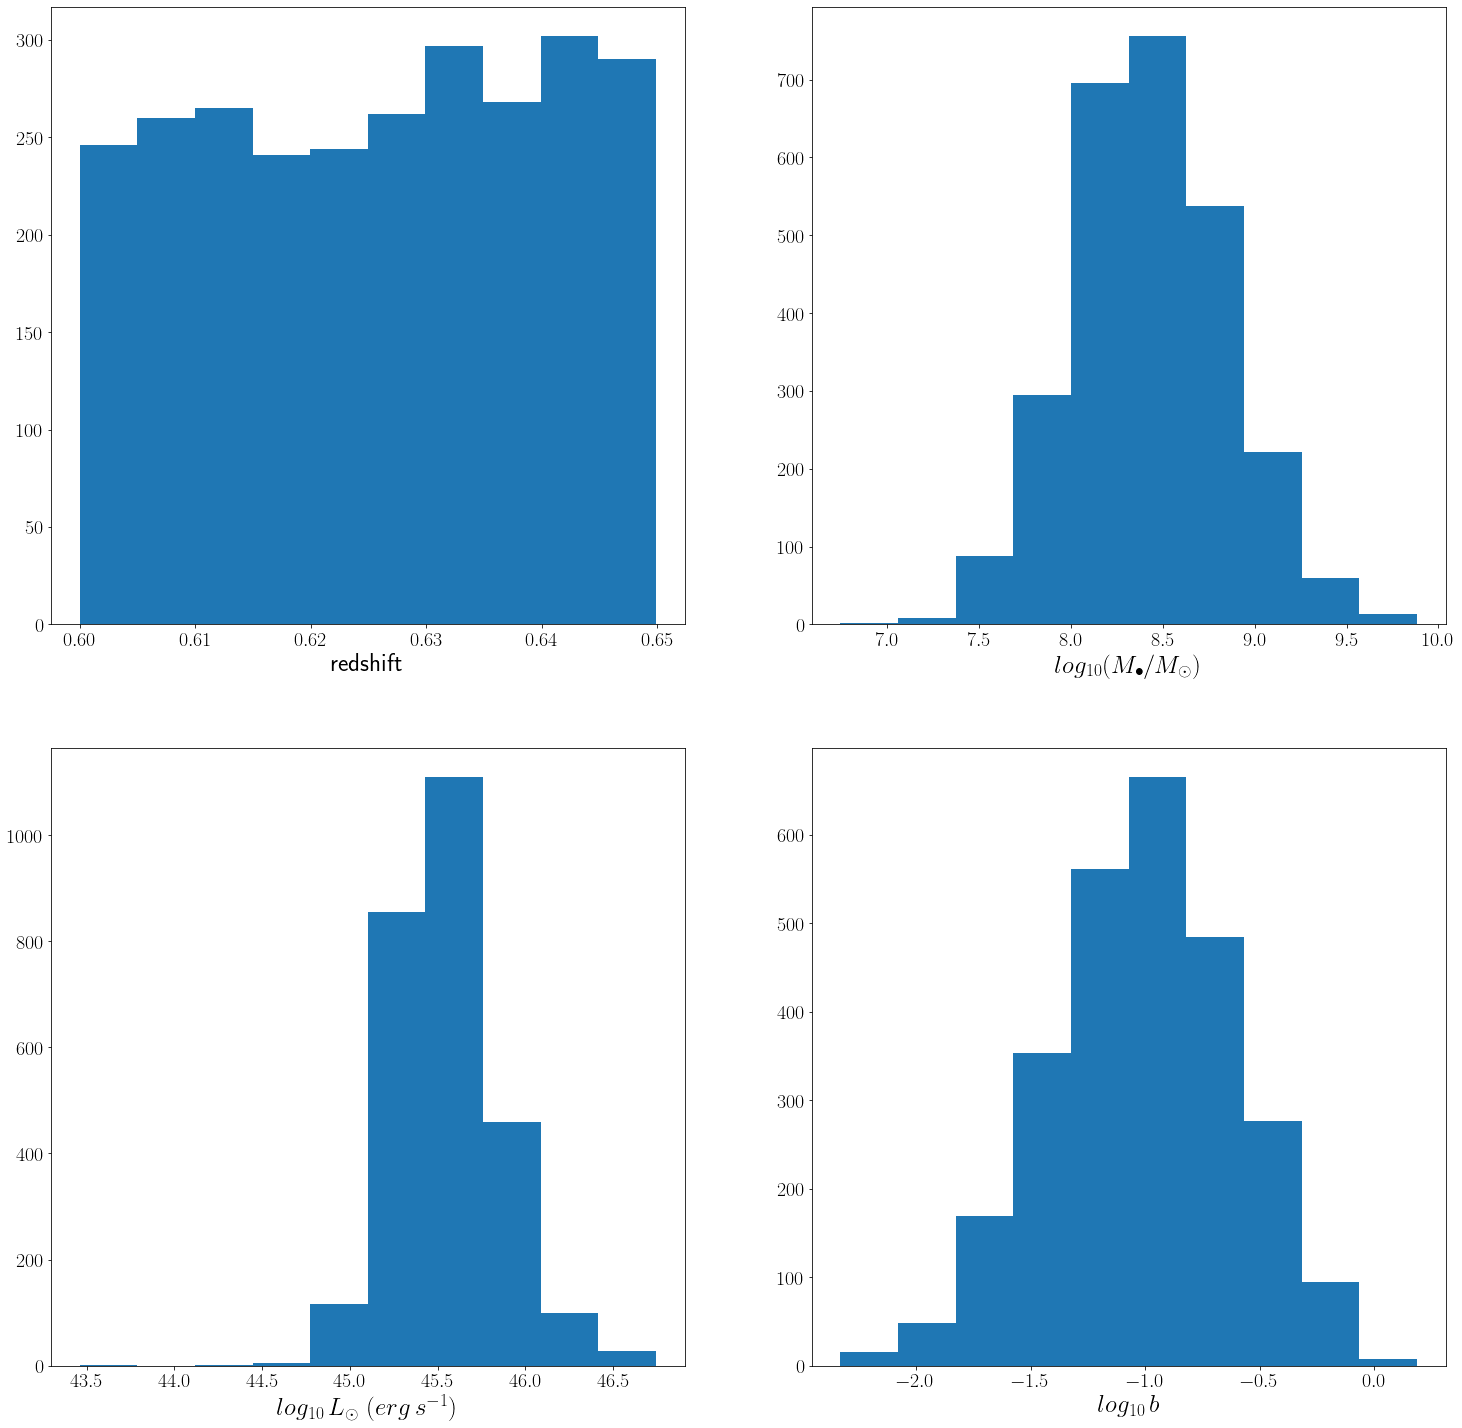

In [3]:
## associate phyiscal parameters from sample catalog with valid objs from dataset
sample_df = pd.read_csv('../../datasets/catalogs/sample_cat')
sample_df = sample_df.set_index('SDSS')
locs = list(set(sample_df.index.values).intersection(set(lcs.valid_files_df.index.values)))
z = sample_df.loc[locs]['z'].values
log_mbh = sample_df.loc[locs]['logMBH'].values
log_lbol = sample_df.loc[locs]['logLbol'].values
log_redd = sample_df.loc[locs]['LogREdd'].values


plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fig, ax = plt.subplots(2,2, figsize=(25,25))
fs = 25

rm_objs = pd.read_csv('../../datasets/catalogs/rm_sample').loc[:,'z'].values
#zs = np.concatenate((rm_objs,z))
#bins = np.arange(np.max(zs), step=0.05)
ax[0][0].hist(z)
ax[0][0].set_xlabel(r'redshift', fontsize=fs)

ax[0][1].hist(log_mbh)
ax[0][1].set_xlabel(r'$log_{10}(M_{\bullet} / M_{\odot})$', fontsize=fs)

ax[1][0].hist(log_lbol)
ax[1][0].set_xlabel(r'$log_{10} \, L_{\odot} \ (erg\, s^{-1})$',fontsize=fs)

ax[1][1].hist(log_redd)
ax[1][1].set_xlabel(r'$log_{10} \, b$',fontsize=fs)

plt.savefig('../img/phys_params_dist')

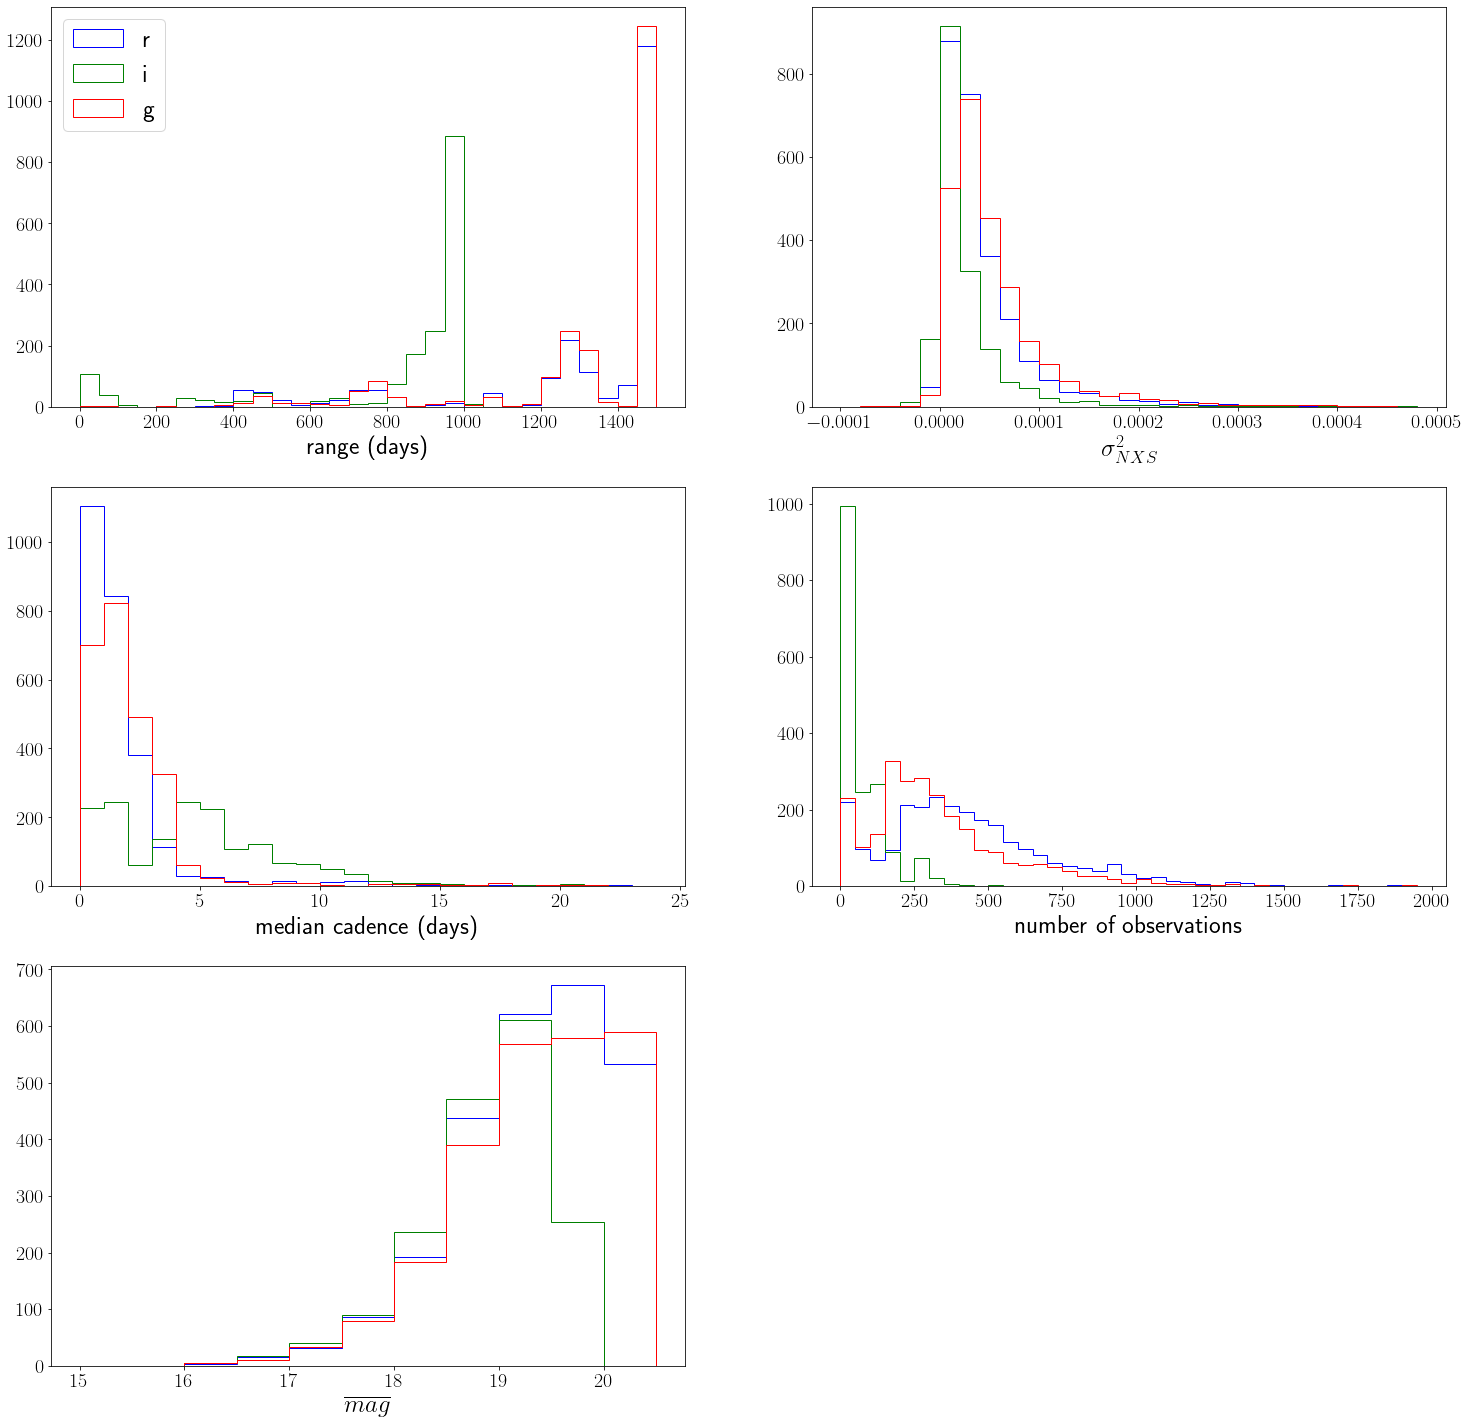

In [4]:
fig, ax = plt.subplots(3,2, figsize=(25,25))

means = lcs.mean_mag
## mean mags   
gtz_r = means[:,0] > 0 ## filter missing data  gtz -> greater than 0 
gtz_i = means[:,1] > 0
gtz_g = means[:,2] > 0
bins = np.arange(15,np.max(means), step=0.5)
ax[2][0].hist(means[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[2][0].hist(means[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[2][0].hist(means[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[2][0].set_xlabel(r'$\overline{mag}$', fontsize=fs)

## range
ranges = np.array([np.ptp(lc[:,0]) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)
bins = np.arange(np.max(ranges), step=50)
ax[0][0].hist(ranges[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[0][0].hist(ranges[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[0][0].hist(ranges[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[0][0].legend(loc="upper left",fontsize=fs)
ax[0][0].set_xlabel(r'range (days)', fontsize=fs)

## med cadence
bins = np.arange(0,25,1)
ax[1][0].hist(lcs.med_cadence[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][0].set_xlabel(r'median cadence (days)',fontsize=fs)

## epochs 
l = np.array([len(lc) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)  
bins = np.arange(2000, step=50)
ax[1][1].hist(l[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][1].hist(l[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][1].hist(l[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][1].set_xlabel(r'number of observations', fontsize=fs)

bins = np.arange(-0.0001, 0.0005, step=0.00002)
ax[0][1].hist(lcs.sigma_nxs[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[0][1].set_xlabel(r'$\sigma^2_{NXS}$',fontsize=fs)

fig.delaxes(ax[2,1])

plt.savefig('../img/sampledist')

## WHICH OBJECT HAVE ANOM PARAMS

In [66]:
n=3
mean_mbh = np.mean(log_mbh)
std_mbh = np.std(log_mbh)

mean_lbol = np.mean(log_lbol)
std_lbol = np.std(log_lbol)

mean_redd = np.mean(log_redd)
std_redd = np.std(log_redd)

anom_mbh = (log_mbh > ((n*std_mbh) + mean_mbh)) | (log_mbh < (mean_mbh - (n*std_mbh)))                                                                                                                     
anom_lbol = (log_lbol > ((n*std_lbol) + mean_lbol)) | (log_lbol < (mean_lbol - (n*std_lbol)))
anom_redd = (log_redd > ((n*std_redd) + mean_redd)) | (log_redd < (mean_redd - (n*std_redd)))


In [105]:
print(f'{anom_mbh.sum()=},{anom_lbol.sum()=},{anom_redd.sum()=}')
anoms = anom_mbh | anom_lbol | anom_redd
print(anoms.sum())
anom_phys_objs = sample_df.loc[locs].index[anoms]

anom_mbh.sum()=10,anom_lbol.sum()=24,anom_redd.sum()=4
32


In [62]:
# could use q1,q2 = np.quantile(means[gtz_g,2], .025), np.quantile(means[gtz_g,2], .975)

n = 3

means_g = means[gtz_g,2]
mean_mean_mag = np.mean(means_g)
std_mean_mag = np.std(means_g)
anom_mean_mag = (means_g > ((n*std_mean_mag) + mean_mean_mag)) | (means_g < (mean_mean_mag - (n*std_mean_mag))) 


ranges_g = ranges[gtz_g,2]
mean_ranges = np.mean(ranges_g)
std_ranges = np.std(ranges_g)
anom_range = (ranges_g > ((n*std_ranges) + mean_ranges)) | (ranges_g < (mean_ranges - (n*std_ranges))) 


med_cads_g = lcs.med_cadence[gtz_g,2]
mean_med_cads = np.mean(med_cads_g)
std_med_cads = np.std(med_cads_g)
anom_med_cad = (med_cads_g > ((n*std_med_cads) + mean_med_cads)) | (med_cads_g < (mean_med_cads - (n*std_med_cads)))


ls_g = l[gtz_g,2]
mean_l = np.mean(ls_g)
std_l = np.std(ls_g)
anom_l = (ls_g > ((n*std_l) + mean_l)) | (ls_g < (mean_l - (n*std_l))) 


nxs_g = lcs.sigma_nxs[gtz_g,2]
mean_nxs = np.mean(nxs_g)
std_nxs = np.std(nxs_g)
anom_nxs = (nxs_g > ((n*std_nxs) + mean_nxs)) | (nxs_g < (mean_nxs - (n*std_nxs))) 


In [64]:
gtz_g_files = lcs.valid_files_df.index[gtz_g]


print(f'{anom_mean_mag.sum()=}, {anom_range.sum()=}, {anom_med_cad.sum()=}, {anom_l.sum()=}, {anom_nxs.sum()=}')
anoms = anom_mean_mag | anom_range | anom_med_cad | anom_l | anom_nxs
anom_lc_stats = gtz_g_files[anoms]

anom_mean_mag.sum()=19, anom_range.sum()=73, anom_med_cad.sum()=50, anom_l.sum()=37, anom_nxs.sum()=42


In [69]:
all_anoms = (anom_phys_objs | anom_lc_stats).to_list()

/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_94675/3987911657.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_anoms = (anom_phys_objs | anom_lc_stats).to_list()


In [76]:

np.savetxt('../anomaly_d/all_anoms', all_anoms, fmt='%s')

np.savetxt('../anomaly_d/pre_anoms/anom_mean_mag', gtz_g_files[anom_mean_mag],fmt='%s')
np.savetxt('../anomaly_d/pre_anoms/anom_range', gtz_g_files[anom_mean_mag],fmt='%s')
np.savetxt('../anomaly_d/pre_anoms/anom_med_cad', gtz_g_files[anom_med_cad], fmt='%s')
np.savetxt('../anomaly_d/pre_anoms/anom_l', gtz_g_files[anom_l], fmt='%s')
np.savetxt('../anomaly_d/pre_anoms/anom_nxs',gtz_g_files[anom_nxs], fmt='%s')


np.savetxt('../anomaly_d/anom_mbh',sample_df.loc[locs].index[anom_mbh], fmt='%s')
np.savetxt('../anomaly_d/anom_lbol',sample_df.loc[locs].index[anom_lbol], fmt='%s')
np.savetxt('../anomaly_d/anom_redd',sample_df.loc[locs].index[anom_redd], fmt='%s')

### Count the number of missing light curves in each band

In [17]:
l = len(lcs.dataset)
lcs_per_obj = (means > 0).sum(axis=1)
one = (lcs_per_obj == 1).sum()
two = (lcs_per_obj == 2).sum()
three = (lcs_per_obj == 3).sum()
print(one, 'missing 2\n',
      two, 'missing 1\n',
      three, 'complete')
print(l-gtz_r.sum(), 'missing in r\n',
      l-gtz_i.sum(), 'missing in i\n',
      l-gtz_g.sum(), 'missing in g\n')

186 missing 2
 791 missing 1
 1698 complete
80 missing in r
 949 missing in i
 134 missing in g



## Light Curve Properties for RM Objects

In [18]:
folder = '../../datasets/ZTF_rm'
min_length=1
sep=','
start_col=1
lcs = DataSet(name=folder, sep=sep, start_col=start_col)
[lcs.add_band(os.path.join(folder, band_folder)) for band_folder in os.listdir(folder)]
lcs.filter(min_length=min_length) 
lcs.prune_outliers()  
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()

validated 9 files out of 9 for band='r'
validated 10 files out of 10 for band='i'
validated 10 files out of 10 for band='g'


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [20]:
lcs.valid_files_df

,r,i,g
MCG+08-11-011,../../datasets/ZTF_rm/r/MCG+08-11-011_DR_rband...,../../datasets/ZTF_rm/i/MCG+08-11-011_DR_iband...,../../datasets/ZTF_rm/g/MCG+08-11-011_DR_gband...
NGC2617,../../datasets/ZTF_rm/r/NGC2617_DR_rband.csv,../../datasets/ZTF_rm/i/NGC2617_DR_iband.csv,../../datasets/ZTF_rm/g/NGC2617_DR_gband.csv
3C120,../../datasets/ZTF_rm/r/3C120_DR_rband.csv,../../datasets/ZTF_rm/i/3C120_DR_iband.csv,../../datasets/ZTF_rm/g/3C120_DR_gband.csv
NGC5548,../../datasets/ZTF_rm/r/NGC5548_DR_rband.csv,../../datasets/ZTF_rm/i/NGC5548_DR_iband.csv,../../datasets/ZTF_rm/g/NGC5548_DR_gband.csv
Mrk876,../../datasets/ZTF_rm/r/Mrk876_DR_rband.csv,../../datasets/ZTF_rm/i/Mrk876_DR_iband.csv,../../datasets/ZTF_rm/g/Mrk876_DR_gband.csv
H2106-099,../../datasets/ZTF_rm/r/H2106-099_DR_rband.csv,../../datasets/ZTF_rm/i/H2106-099_DR_iband.csv,../../datasets/ZTF_rm/g/H2106-099_DR_gband.csv
Mrk142,../../datasets/ZTF_rm/r/Mrk142_DR_rband.csv,../../datasets/ZTF_rm/i/Mrk142_DR_iband.csv,../../datasets/ZTF_rm/g/Mrk142_DR_gband.csv
Mrk817,../../datasets/ZTF_rm/r/Mrk817_DR_rband.csv,../../datasets/ZTF_rm/i/Mrk817_DR_iband.csv,../../datasets/ZTF_rm/g/Mrk817_DR_gband.csv


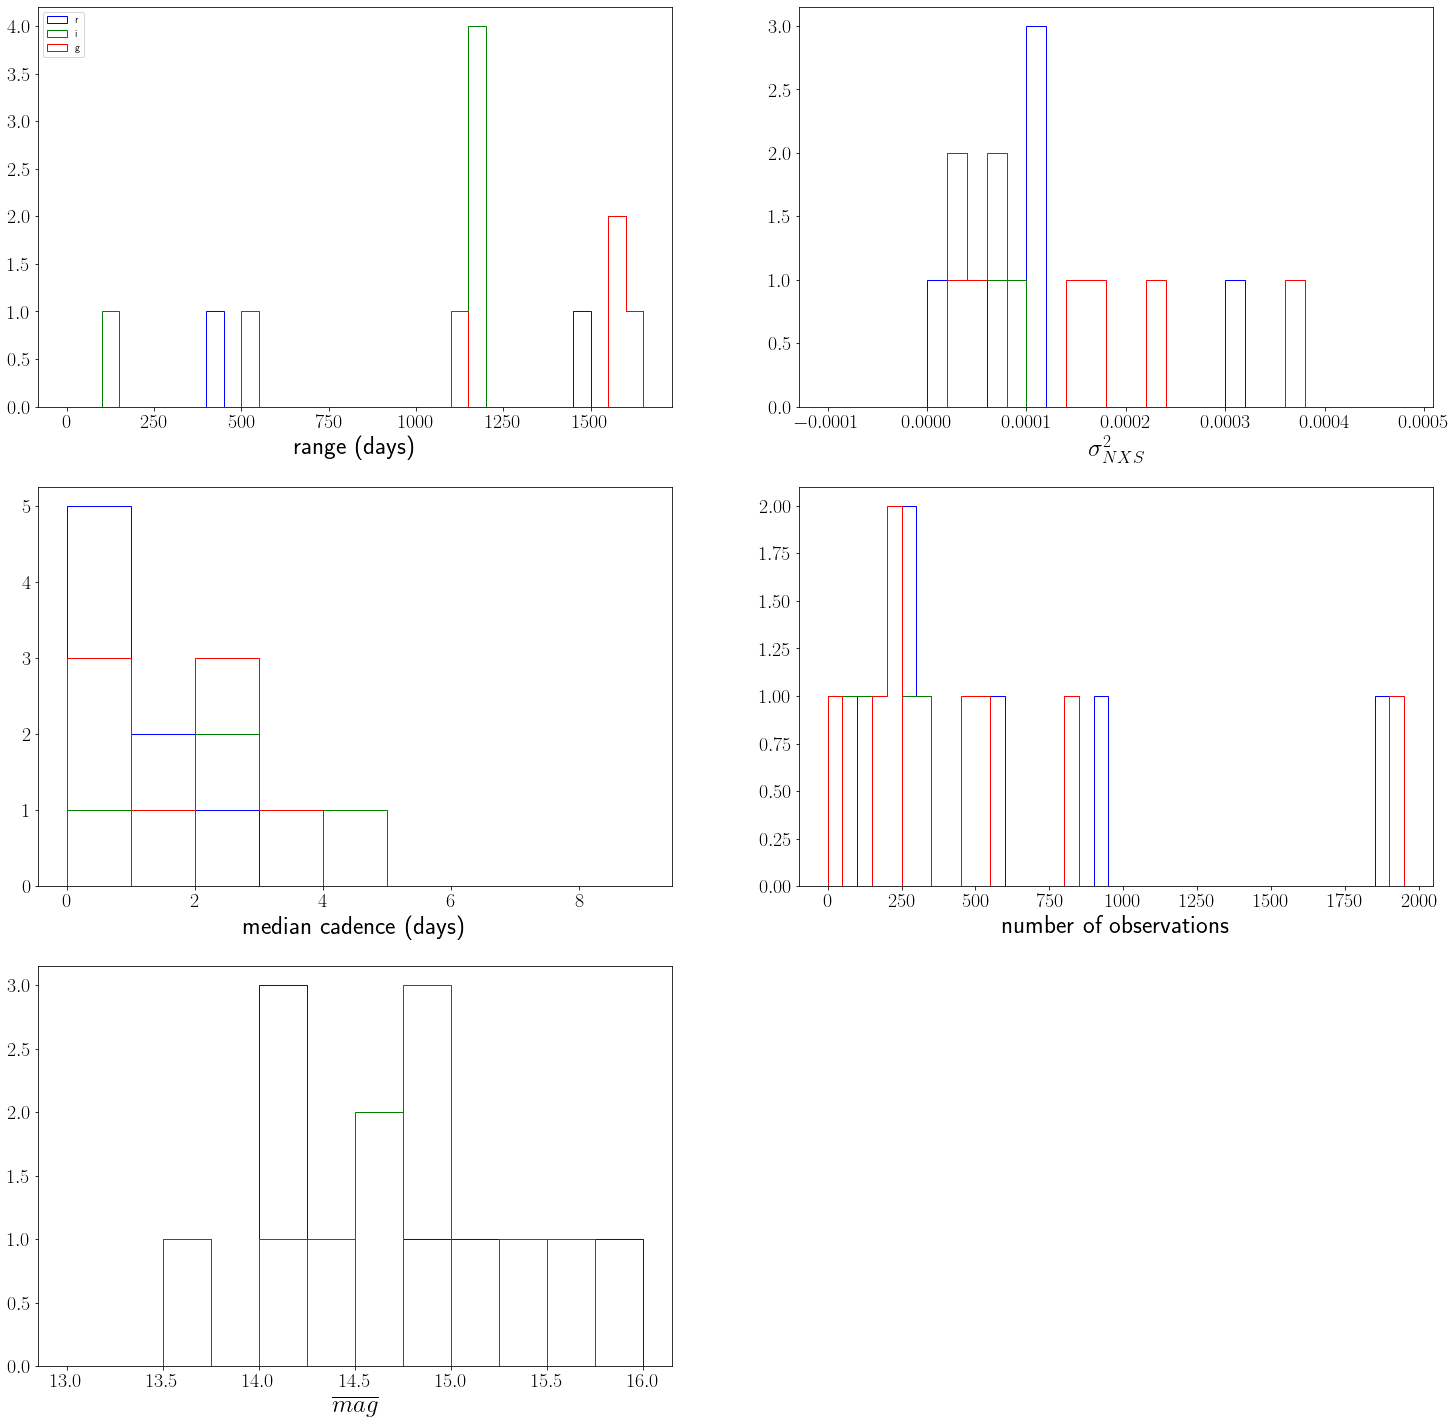

In [21]:
fig, ax = plt.subplots(3,2, figsize=(25,25))

means = lcs.mean_mag
## mean mags   
gtz_r = means[:,0] > 0 ## filter missing data 
gtz_i = means[:,1] > 0
gtz_g = means[:,2] > 0
bins = np.arange(13,np.max(means), step=0.25)
ax[2][0].hist(means[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[2][0].hist(means[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[2][0].hist(means[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[2][0].set_xlabel(r'$\overline{mag}$', fontsize=fs)

## range
ranges = np.array([np.ptp(lc[:,0]) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)
bins = np.arange(np.max(ranges), step=50)
ax[0][0].hist(ranges[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[0][0].hist(ranges[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[0][0].hist(ranges[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r'range (days)', fontsize=fs)

## med cadence
bins = np.arange(0,10,1)
ax[1][0].hist(lcs.med_cadence[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][0].set_xlabel(r'median cadence (days)',fontsize=fs)

## epochs 
l = np.array([len(lc) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)   
bins = np.arange(2000, step=50)
ax[1][1].hist(l[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][1].hist(l[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][1].hist(l[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][1].set_xlabel(r'number of observations', fontsize=fs)

## normalized xs variance
bins = np.arange(-0.0001, 0.0005, step=0.00002)
ax[0][1].hist(lcs.sigma_nxs[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[0][1].set_xlabel(r'$\sigma^2_{NXS}$',fontsize=fs)

fig.delaxes(ax[2,1])

plt.savefig('../img/rm_objs_dist')

In [22]:
l = len(lcs.dataset)

lcs_per_obj = (means > 0).sum(axis=1)
one = (lcs_per_obj == 1).sum()
two = (lcs_per_obj == 2).sum()
three = (lcs_per_obj == 3).sum()

print(one, 'missing 2\n',
      two, 'missing 1\n',
      three, 'complete')
print(l-gtz_r.sum(), 'missing in r\n',
      l-gtz_i.sum(), 'missing in i\n',
      l-gtz_g.sum(), 'missing in g\n')

0 missing 2
 3 missing 1
 5 complete
0 missing in r
 3 missing in i
 0 missing in g

